**Comparision with different embedding size ( 64,128 and 512)**

### Euclidean Distance – Embedding Size vs Accuracy & Loss

| **Embedding Size** | **Val Accuracy** | **Val Loss** | **observation**                          |
|--------------------|------------------|--------------|--------------------------------------|
| 64           | 0.4785           | 1.8241       | Lowest accuracy, is probably underfitting        |
| **128**            | **0.5015**      | **1.7754**       | **Best accuracy and lowest loss**       |
| 512           | 0.4901           | 1.8189       | Slight improvement over 64, but is unstable |


From 64 to 128 size the model shows improvement in accuracy and loss
But from 128 to 512, the accuracy drops due to overfitting.


### Squared Euclidean Distance – Embedding Size vs Accuracy & Loss

| **Embedding Size** | **Val Accuracy** | **Val Loss** | **Observation**                            |
|--------------------|------------------|--------------|----------------------------------------|
| 64             | 0.3951           | 6.4476       |  Underfitting  |
| **128**            | **0.5005**         | **1.7778**      | **Best accuracy and loss**               |
| 512            | 0.4905           | 1.8220       | Slight overfitting, unstable in high-dim |

In Squared Euclidean diatance there was a major jump from 6.4476 val loss to 1.7778 indicating increase in accuracy and generalisation
but from 128 to 512 there seem to be slight overfitting and also instability.


Overall, the results clearly indicate that an embedding size of 128 yields the best performance across both Euclidean and squared Euclidean distance metrics.




References

### For distance implementation referred PyTorch official documentation (for tensor operations: torch.sum, torch.abs, etc.)

In [ ]:
from time import perf_counter
from typing import Tuple, Dict, Optional, Callable

import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from torch import nn
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, RandomCrop, RandomHorizontalFlip, Compose, CenterCrop, RandomAffine, ColorJitter

from boilerplate import get_accuracy
from boilerplate import count_parameters, plot_learning_curves, EarlyStopping

## Loading Data

This first part just serves to get the actual CIFAR100 data. We then *combine* the training and test sets, since we actually want to split the data *by class*.

There are also some data augmentation transforms defined here; to be quite honest this is just because I was lazily copy-pasting from previous assignments. But these transforms are then later used when training the actual Prototypical Networks, as well.

In [ ]:
train_transforms = []
test_transforms = []

flip = True
rotation = 15
scale = (0.8, 1.2)
color = (0.95, 1.05)
translation = 0.1

if color is not None:
    train_transforms.append(ColorJitter(color, color, color, (color[0]-1, color[1]-1)))  # brightness, contrast, saturation, hue
if rotation > 0 or scale is not None:
    train_transforms.append(RandomAffine(degrees=rotation,
                                         translate=(translation, translation),
                                         scale=scale))
if flip:
    train_transforms.append(RandomHorizontalFlip())

train_transforms.append(ToTensor())
test_transforms.append(ToTensor())

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
train_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=Compose(train_transforms))

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=Compose(test_transforms))

100%|██████████| 169M/169M [00:06<00:00, 27.3MB/s]


In [ ]:
all_images = np.concatenate((train_data.data, test_data.data), axis=0)
all_targets = np.concatenate((train_data.targets, test_data.targets), axis=0)

## Splitting By Class

CIFAR100 has 100 classes which are summarized in 20 "superclasses". I decided to split into training/validation/test by those superclasses -- for each superclass, three classes go into training, and one each into validation/test. I thought this might make it easier, since the model has at least seen each "superclass" evenly. The "problem" is that this forces us into a 60/20/20 split, which is relatively little training data, just 36000 points.

Also note that performance may depend heavily on which classes end up in training/test sets -- some classes may be easier to generalize to than others. As such, a detailed evaluation of our models would involve different splits. You can change the `seed` of the permutation further below to change the split.

In [ ]:
# I just copied this from the CIFAR100 website.
# I stated putting quotation marks and brackets [] around stuff, then I got sick of it.
"""
{"aquatic mammals": 	[beaver, dolphin, otter, seal, whale],
"fish": 	[aquarium fish, flatfish, ray, shark, trout],
"flowers": 	[orchids, poppies, roses, sunflowers, tulips],
"food containers": 	[bottles, bowls, cans, cups, plates],
"fruit and vegetables": 	[apples, mushrooms, oranges, pears, sweet peppers],
"household electrical devices": 	[clock, computer keyboard, lamp, telephone, television],
"household furniture": 	[bed, chair, couch, table, wardrobe],
"insects": 	[bee, beetle, butterfly, caterpillar, cockroach],
"large carnivores": 	[bear, leopard, lion, tiger, wolf],
"large man-made outdoor things": 	[bridge, castle, house, road, skyscraper],
"large natural outdoor scenes": 	[cloud, forest, mountain, plain, sea],
"large omnivores and herbivores": 	[camel, cattle, chimpanzee, elephant, kangaroo],
"medium-sized mammals": 	[fox, porcupine, possum, raccoon, skunk],
"non-insect invertebrates": 	[crab, lobster, snail, spider, worm],
"people": 	[baby, boy, girl, man, woman],
"reptiles": 	[crocodile, dinosaur, lizard, snake, turtle],
"small mammals": 	[hamster, mouse, rabbit, shrew, squirrel],
"trees": 	[maple, oak, palm, pine, willow],
"vehicles 1": 	[bicycle, bus, motorcycle, pickup truck, train],
"vehicles 2": 	[lawn-mower, rocket, streetcar, tank, tractor]}
"""

'\n{"aquatic mammals": \t[beaver, dolphin, otter, seal, whale],\n"fish": \t[aquarium fish, flatfish, ray, shark, trout],\n"flowers": \t[orchids, poppies, roses, sunflowers, tulips],\n"food containers": \t[bottles, bowls, cans, cups, plates],\n"fruit and vegetables": \t[apples, mushrooms, oranges, pears, sweet peppers],\n"household electrical devices": \t[clock, computer keyboard, lamp, telephone, television],\n"household furniture": \t[bed, chair, couch, table, wardrobe],\n"insects": \t[bee, beetle, butterfly, caterpillar, cockroach],\n"large carnivores": \t[bear, leopard, lion, tiger, wolf],\n"large man-made outdoor things": \t[bridge, castle, house, road, skyscraper],\n"large natural outdoor scenes": \t[cloud, forest, mountain, plain, sea],\n"large omnivores and herbivores": \t[camel, cattle, chimpanzee, elephant, kangaroo],\n"medium-sized mammals": \t[fox, porcupine, possum, raccoon, skunk],\n"non-insect invertebrates": \t[crab, lobster, snail, spider, worm],\n"people": \t[baby, boy

In [ ]:
# I USED CHATGPT TO PUT QUOTATION MARKS AROUND THE WORDS OK?!
# and then I had to rename some of the classes to fit with the torchvision CIFAR100 class

superclasses = {
  "aquatic mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
  "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
  "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
  "food containers": ["bottle", "bowl", "can", "cup", "plate"],
  "fruit and vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
  "household electrical devices": ["clock", "keyboard", "lamp", "telephone", "television"],
  "household furniture": ["bed", "chair", "couch", "table", "wardrobe"],
  "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
  "large carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
  "large man-made outdoor things": ["bridge", "castle", "house", "road", "skyscraper"],
  "large natural outdoor scenes": ["cloud", "forest", "mountain", "plain", "sea"],
  "large omnivores and herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
  "medium-sized mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
  "non-insect invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
  "people": ["baby", "boy", "girl", "man", "woman"],
  "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
  "small mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
  "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
  "vehicles 1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
  "vehicles 2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"]
}

In [ ]:
superclasses_keys = list(superclasses.keys())
superclasses_keys

['aquatic mammals',
 'fish',
 'flowers',
 'food containers',
 'fruit and vegetables',
 'household electrical devices',
 'household furniture',
 'insects',
 'large carnivores',
 'large man-made outdoor things',
 'large natural outdoor scenes',
 'large omnivores and herbivores',
 'medium-sized mammals',
 'non-insect invertebrates',
 'people',
 'reptiles',
 'small mammals',
 'trees',
 'vehicles 1',
 'vehicles 2']

In [ ]:
superclasses_index_map = []
for supclass in superclasses_keys:  # iterate over list to guarantee ordering
    classes = superclasses[supclass]
    classes_ind = [train_data.class_to_idx[subclass] for subclass in classes]
    superclasses_index_map.append(classes_ind)
superclasses_index_map = np.array(superclasses_index_map)
superclasses_index_map

array([[ 4, 30, 55, 72, 95],
       [ 1, 32, 67, 73, 91],
       [54, 62, 70, 82, 92],
       [ 9, 10, 16, 28, 61],
       [ 0, 51, 53, 57, 83],
       [22, 39, 40, 86, 87],
       [ 5, 20, 25, 84, 94],
       [ 6,  7, 14, 18, 24],
       [ 3, 42, 43, 88, 97],
       [12, 17, 37, 68, 76],
       [23, 33, 49, 60, 71],
       [15, 19, 21, 31, 38],
       [34, 63, 64, 66, 75],
       [26, 45, 77, 79, 99],
       [ 2, 11, 35, 46, 98],
       [27, 29, 44, 78, 93],
       [36, 50, 65, 74, 80],
       [47, 52, 56, 59, 96],
       [ 8, 13, 48, 58, 90],
       [41, 69, 81, 85, 89]])

In [ ]:
# for each superclass, we choose one class each for validation and test sets;
# the other three go into training
n_superclasses = superclasses_index_map.shape[0]
superclass_indices_train = np.zeros((n_superclasses, 3), dtype=np.int32)
superclass_indices_valid = np.zeros((n_superclasses, 1), dtype=np.int32)
superclass_indices_test = np.zeros((n_superclasses, 1), dtype=np.int32)

# change this seed to change the split!
seed = 12
rng = np.random.default_rng(seed)
for ind_spc, classes in enumerate(superclasses_index_map):
    permute = rng.permutation(classes)
    superclass_indices_train[ind_spc] = permute[:3]
    superclass_indices_valid[ind_spc] = permute[3]
    superclass_indices_test[ind_spc] = permute[4]
    print(permute)

[30 55 72 95  4]
[32 91 73  1 67]
[92 62 82 70 54]
[10 16 61 28  9]
[51 83 57 53  0]
[22 39 40 86 87]
[20 25 84 94  5]
[24 18  6 14  7]
[ 3 97 88 43 42]
[12 68 37 17 76]
[23 49 71 60 33]
[21 38 31 19 15]
[66 64 34 75 63]
[45 26 99 77 79]
[46 98 11  2 35]
[78 29 93 27 44]
[36 74 65 80 50]
[56 52 59 96 47]
[90 58 13 48  8]
[89 81 85 41 69]


In [ ]:
superclass_indices_test

array([[ 4],
       [67],
       [54],
       [ 9],
       [ 0],
       [87],
       [ 5],
       [ 7],
       [42],
       [76],
       [33],
       [15],
       [63],
       [79],
       [35],
       [44],
       [50],
       [47],
       [ 8],
       [69]], dtype=int32)

Now we write our own dataset. An important component here is a map `class_indices` that gives, for each class, the indices in the dataset belonging to this class. This will later allow us to sample elements specifically for previously chosen classes. This differs from our usual fully random sampling. Note that, mainly due to laziness, each dataset receives _all_ images. But we will later take care to only sample from the respective subset.

In [ ]:
class ProtoCIFAR100(Dataset):
    def __init__(self,
                 images: np.ndarray,
                 targets: np.ndarray,
                 super_to_sub_map: np.ndarray,
                 transform: Optional = None):
        super().__init__()
        self.transform = transform
        self.data = images
        self.targets = targets

        self.super_to_sub_map = super_to_sub_map
        self.classes_flat = super_to_sub_map.reshape(-1)

        self.class_indices = {}
        for index in self.classes_flat:
            self.class_indices[index] = torch.tensor(np.where(self.targets == index)[0])

        _, self.class_counts = np.unique(targets, return_counts=True)

    def __getitem__(self,
                    index: int):
        img, target = self.data[index], self.targets[index]

        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        total_count = 0
        for _class in self.classes_flat:
            total_count += self.class_counts[_class]
        return total_count

In [ ]:
train_data = ProtoCIFAR100(all_images, all_targets, superclass_indices_train, transform=Compose(train_transforms))
valid_data = ProtoCIFAR100(all_images, all_targets, superclass_indices_valid, transform=Compose(test_transforms))
test_data = ProtoCIFAR100(all_images, all_targets, superclass_indices_test, transform=Compose(test_transforms))

Finally, we write a custom `Sampler` that is then used by the `DataLoader`. This class is responsible for supplying indices, which the dataloader then uses to actually index into the data.

To keep things simple, we use sampling "with replacement". That is, for each batch, we randomly sample some data, with no regard for "iterating" over the dataset as we usually would do. This means that there is no real concept of epochs, and we may sample some elements from the dataset more often than others. Statistically, in the long run, this is still the same as a "clean" iteration over the data. It is, however, much easier to implement in our case. The main thing that would make iteration hard is that we only sample a subset of classes at each step to keep batch size in control. Handling this in a way that all classes are sampled equally often would be quite complicated.

Basically our sampler
- Chooses a random subset of classes from the dataset.
- For each class, samples `n_support + n_query` elements from the data.
- The above process is one batch; we arbitrarily define an epoch as a pre-defined number of batches.

The resulting batch is returned in just one dimension, i.e. the "batch size" is `num_classes_sampled * n_support * n_query`. Of course we later need to split this batch into the different classes as well as support and query sets; this is handled in the training step function which simply assumes the incoming data follows the format that is constructed in this sampler. This whole thing is a bit brittle, but easier to implement this way, as we can use the standard `DataLoader` class. An alternative would be to use our own dataloader, or at least `collate_fn` (remember the IMDB assignment), to split the data into the respective subsets and give the data to the training step already in the correct format.

In [ ]:
class SubclassBatchSampler(Sampler):
    def __init__(self,
                 datasource: Dataset,
                 n_support: int,
                 n_query: int,
                 classes_per_batch: int,
                 batches_per_epoch: int):
        self.datasource = datasource
        self.n_support = n_support
        self.n_query = n_query
        self.classes_per_batch = classes_per_batch
        self.batches_per_epoch = batches_per_epoch

    def __iter__(self):
        available_classes = self.datasource.classes_flat
        n_classes = len(available_classes)
        if self.classes_per_batch is None or self.classes_per_batch == n_classes:
            sample_classes = False
        else:
            sample_classes = True

        for batch_ind in range(self.batches_per_epoch):
            if sample_classes:
                chosen_class_indices = torch.randperm(n_classes)[:self.classes_per_batch]
                chosen_classes = available_classes[chosen_class_indices]
            else:
                chosen_classes = available_classes

            dataset_indices = []
            for _class in chosen_classes:
                n_samples_for_class = self.datasource.class_counts[_class]
                class_indices = torch.randperm(n_samples_for_class)[:self.n_support + self.n_query]
                dataset_indices.append(self.datasource.class_indices[_class.item()][class_indices])

            yield torch.cat(dataset_indices)

    def __len__(self):
        return self.batches_per_epoch

In [ ]:
n_support = 5
n_query = 10
classes_per_batch = 20
batches_per_epoch = 200


train_sampler = SubclassBatchSampler(train_data, n_support=n_support, n_query=n_query, classes_per_batch=classes_per_batch,
                                     batches_per_epoch=batches_per_epoch)
valid_sampler = SubclassBatchSampler(valid_data, n_support=n_support, n_query=n_query, classes_per_batch=classes_per_batch,
                                     batches_per_epoch=batches_per_epoch)
test_sampler = SubclassBatchSampler(test_data, n_support=n_support, n_query=n_query, classes_per_batch=classes_per_batch,
                                    batches_per_epoch=batches_per_epoch)

Here we print one batch of our sampler. Observe how we get classes in sequence, i.e. all samples are of one class, then it switches ot another class, etc. If you were to count, you would see that there are `n_support + n_query` samples per class, and `classes_per_batch` classes in total. You can play with these numbers if you want.

In particular, if you later find training time to be intolerably high, you could reduce `n_query` and/or `classes_per_batch`. You could also reduce `n_support`, but this fundamentally changes the learning problem -- for example, in the extreme, `n_support = 1` corresponds to so-called one-shot learning.

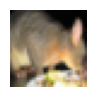

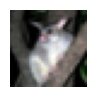

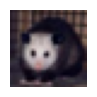

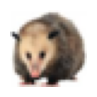

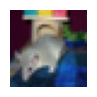

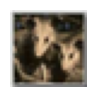

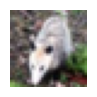

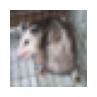

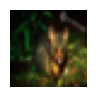

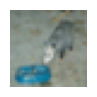

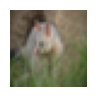

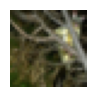

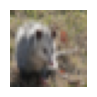

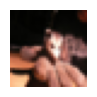

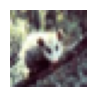

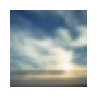

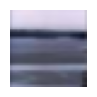

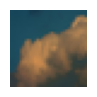

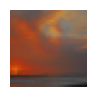

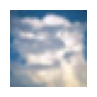

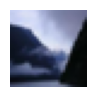

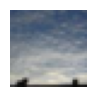

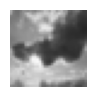

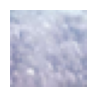

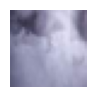

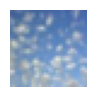

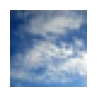

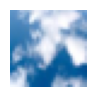

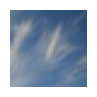

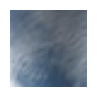

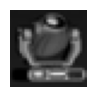

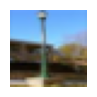

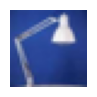

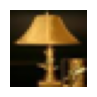

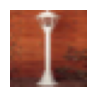

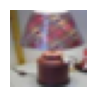

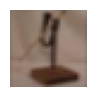

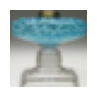

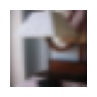

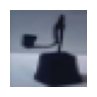

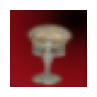

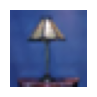

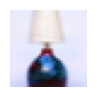

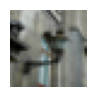

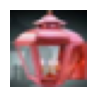

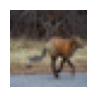

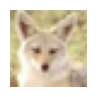

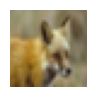

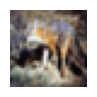

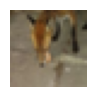

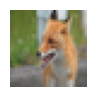

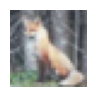

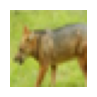

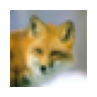

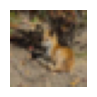

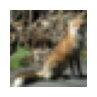

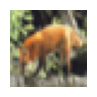

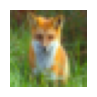

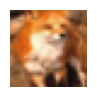

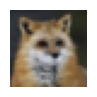

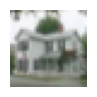

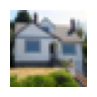

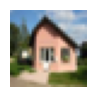

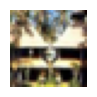

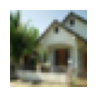

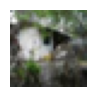

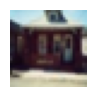

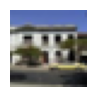

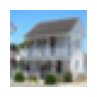

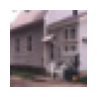

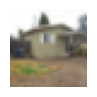

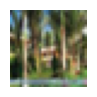

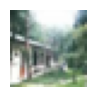

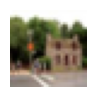

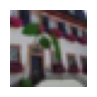

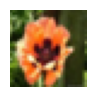

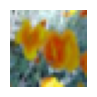

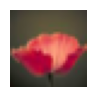

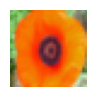

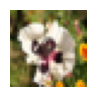

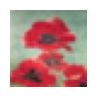

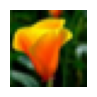

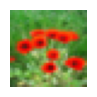

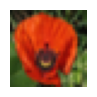

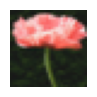

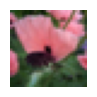

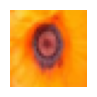

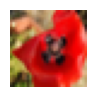

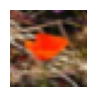

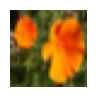

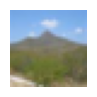

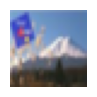

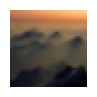

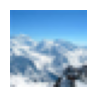

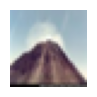

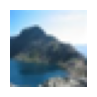

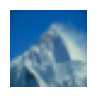

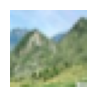

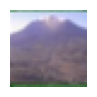

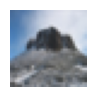

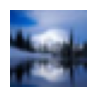

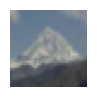

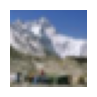

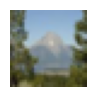

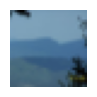

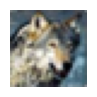

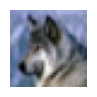

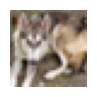

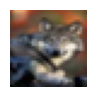

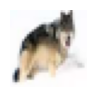

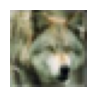

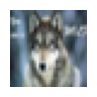

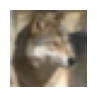

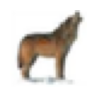

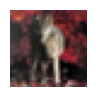

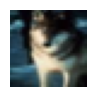

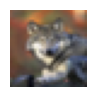

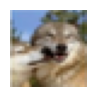

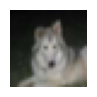

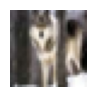

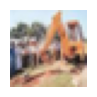

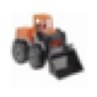

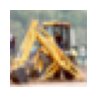

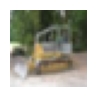

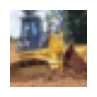

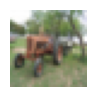

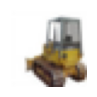

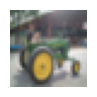

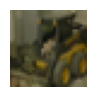

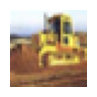

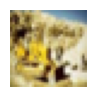

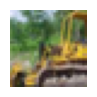

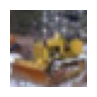

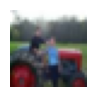

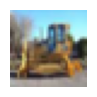

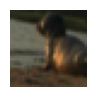

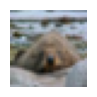

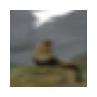

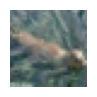

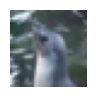

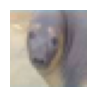

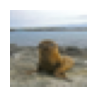

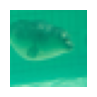

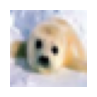

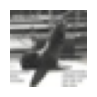

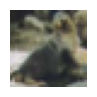

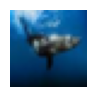

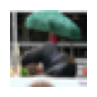

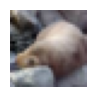

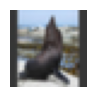

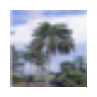

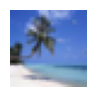

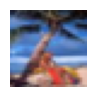

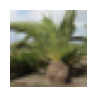

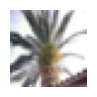

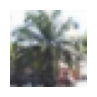

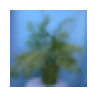

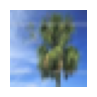

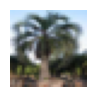

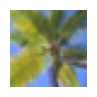

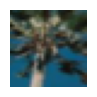

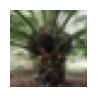

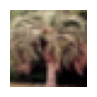

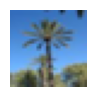

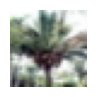

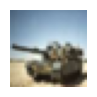

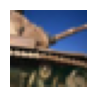

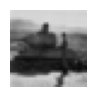

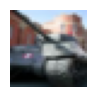

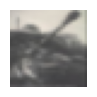

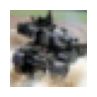

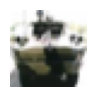

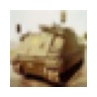

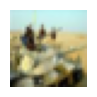

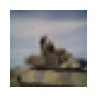

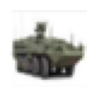

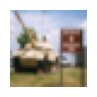

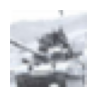

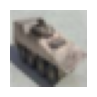

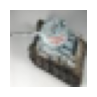

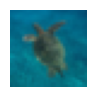

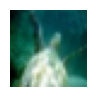

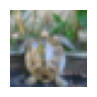

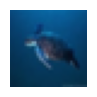

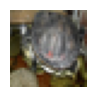

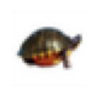

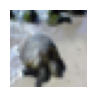

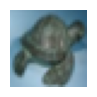

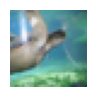

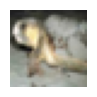

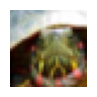

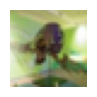

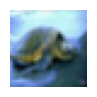

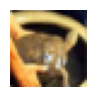

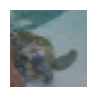

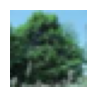

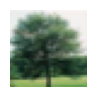

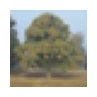

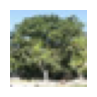

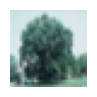

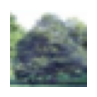

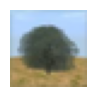

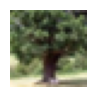

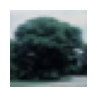

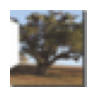

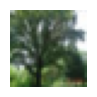

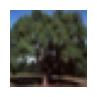

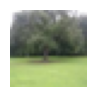

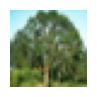

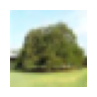

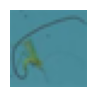

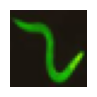

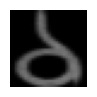

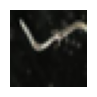

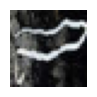

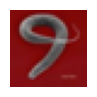

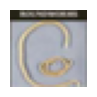

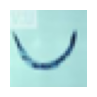

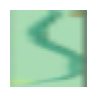

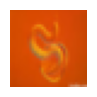

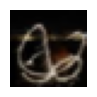

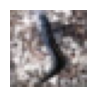

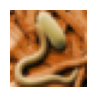

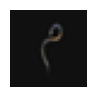

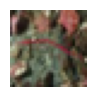

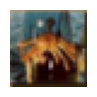

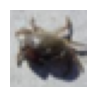

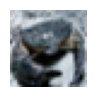

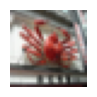

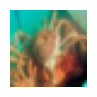

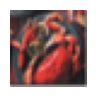

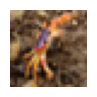

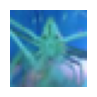

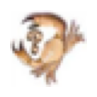

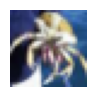

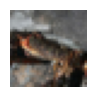

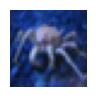

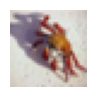

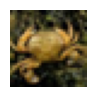

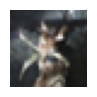

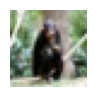

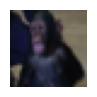

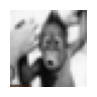

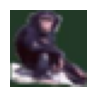

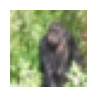

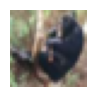

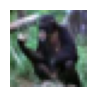

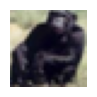

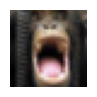

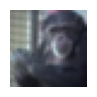

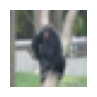

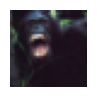

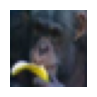

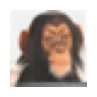

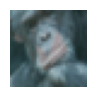

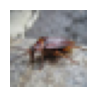

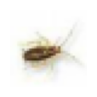

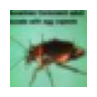

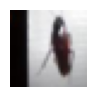

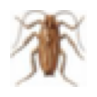

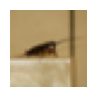

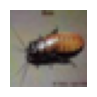

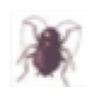

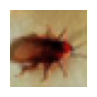

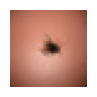

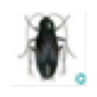

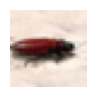

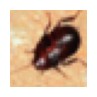

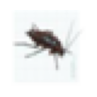

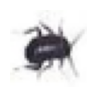

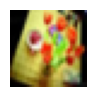

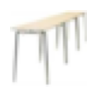

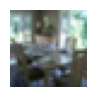

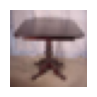

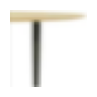

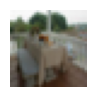

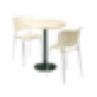

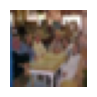

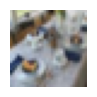

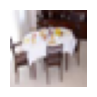

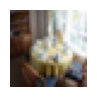

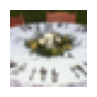

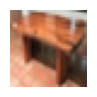

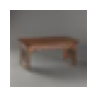

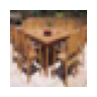

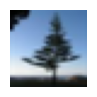

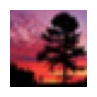

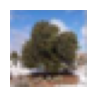

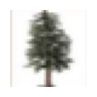

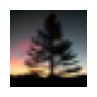

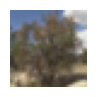

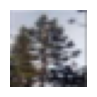

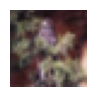

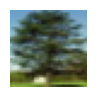

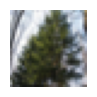

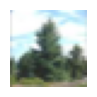

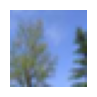

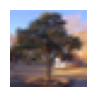

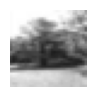

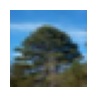

In [ ]:
for thing in train_sampler:
    #print(thing)
    for ind in thing:
        plt.figure(figsize=(1,1))
        plt.axis("off")
        plt.imshow(train_data.data[ind])
        plt.show()
    break

As usual, you may have to reduce `num_workers` depending on your machine!

In [ ]:
train_dataloader = DataLoader(train_data, batch_sampler=train_sampler, pin_memory=True,
                              num_workers=16)
valid_dataloader = DataLoader(valid_data, batch_sampler=valid_sampler, pin_memory=True,
                              num_workers=16)
test_dataloader = DataLoader(test_data, batch_sampler=test_sampler, pin_memory=True,
                             num_workers=16)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Shape of X [N, C, H, W]: torch.Size([300, 3, 32, 32])
Shape of y: torch.Size([300]) torch.int64


In [ ]:
len(train_sampler)

200

## Model

We can build any model that takes in a CIFAR100 image and returns a vector. So you can use any of our previously used CNN architectures. It just has to result in a vector output. Do not include the typical classificaton layer at the end!

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

embed_dim = 64

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten()
)
model.append(nn.LazyLinear(embed_dim))

# run model to initialize lazy layers
model = model.to(device)
with torch.no_grad():
    test = model(next(iter(train_dataloader))[0].to(device))
print(model)
print(test.shape)

Using cuda device


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=1024, out_features=64, bias=True)
)
torch.Size([300, 64])


In [ ]:
num_params = count_parameters(model)
print("Model with {} trainable parameters".format(num_params))

Model with 89184 trainable parameters


In [ ]:
# the usual....
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)

This is our core logic for training and evaluating. There are a few steps left to fill in. The distance functions are relatively time-efficient, but rather space-inefficient, methods to compute the distance between all prototypes and all queries at once. It relies on _broadcasting_ to replicate the protoypes over the query axis, and the queries over the prototype axis. You should be able to apply this principle to also compute other functions besides euclidean distance!

Aside from that, the `prototype_step` handles the main logic of splitting the batch into support and query sets, and split into the different classes, as well as computing embeddings, distances, and logits for classification.

In [ ]:
def euclidean_distance(prototypes, queries):
    return torch.sqrt(torch.square(prototypes[:, torch.newaxis, :] - queries[torch.newaxis, :, :]).sum(dim=-1))

# For distance implementation referred PyTorch official documentation (for tensor operations: torch.sum, torch.abs, etc.)
def squared_euclidean_distance(prototypes, queries):
    return torch.sum((prototypes[:, None, :] - queries[None, :, :]) ** 2, dim=-1)


def abs_distance(prototypes, queries):
     return torch.sum(torch.abs(prototypes[:, None, :] - queries[None, :, :]), dim=-1)


def dot_distance(prototypes, queries):
     return -torch.matmul(prototypes, queries.T)


def prototype_step(image_batch: torch.Tensor,
                   model: nn.Module,
                   n_support: int,
                   n_query: int,
                   distance_fn: Callable):
    # down below:
    # n_per_class is n_support + n_query
    # b is n_classes * n_query (i.e. total query batch size)

    # image_batch is the whole "episode" -- support and query for all classes

    embeddings = model(image_batch)  # batch x features
    per_class = embeddings.view(-1, n_support + n_query, embeddings.shape[-1])  # classes x (n_per_class) x features
    # you got to extract support and query sets from the per_class tensor
    embeddings_support = per_class[:, :n_support, :]  # should be classes x n_support x features
    embeddings_query = per_class[:, n_support:, :]  # should be classes x n_query x features
    queries_flat = embeddings_query.reshape(-1, embeddings.shape[-1])  # b x features

    prototypes = embeddings_support.mean(dim=1)  # result should be classes x features

    distances = distance_fn(prototypes, queries_flat)  # classes x b
    logits = -distances.T  # b x classes
    labels = torch.repeat_interleave(torch.arange(prototypes.shape[0], device=logits.device), n_query)

    return logits, labels


def train_step(image_batch: torch.Tensor,
               model: nn.Module,
               n_support: int,
               n_query: int,
               distance_fn: Callable,
               loss_fn: Callable,
               optimizer: torch.optim.Optimizer,
               device: str):
    image_batch = image_batch.to(device)
    logits, labels = prototype_step(image_batch, model, n_support, n_query, distance_fn)
    loss = loss_fn(logits, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        batch_accuracy = get_accuracy(labels, logits)
    return loss, batch_accuracy


def validate(dataloader: DataLoader,
             model: nn.Module,
             distance_fn: Callable,
             loss_fn: Callable,
             device: str) -> Tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    n_support = dataloader.batch_sampler.n_support
    n_query = dataloader.batch_sampler.n_query

    with torch.no_grad():
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            logits, labels = prototype_step(image_batch, model, n_support, n_query, distance_fn)

            val_loss += loss_fn(logits, labels)
            n_classes = logits.shape[-1]
            correct += (logits.argmax(axis=1) == labels).type(torch.float).sum()

        val_loss /= num_batches
        val_accuracy = correct / (num_batches * n_query * n_classes)
    return val_loss, val_accuracy


def validate_per_episode(dataloader: DataLoader,
                         model: nn.Module,
                         distance_fn: Callable,
                         loss_fn: Callable,
                         device: str) -> Tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    num_batches = len(dataloader)
    losses = []
    accuracies = []
    n_support = dataloader.batch_sampler.n_support
    n_query = dataloader.batch_sampler.n_query

    with torch.no_grad():
        for image_batch, _ in dataloader:
            batch_size = image_batch.shape[0]
            image_batch = image_batch.to(device)
            logits, labels = prototype_step(image_batch, model, n_support, n_query, distance_fn)
            losses.append(loss_fn(logits, labels).cpu().numpy())
            accuracies.append((logits.argmax(axis=1) == labels).type(torch.float).mean().cpu().numpy())

    return losses, accuracies


def train_model(model: nn.Module,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler.LRScheduler,
                training_loader: DataLoader,
                validation_loader: DataLoader,
                n_epochs: int,
                device: str,
                verbose: bool = True) -> Dict[str, np.ndarray]:
    batches_per_epoch = len(training_loader)
    print("Running {} epochs at {} steps per epoch.".format(n_epochs, batches_per_epoch))

    # note, for training we only track the average over the epoch.
    # this is somewhat imprecise, as the model changes over the epoch.
    # so the metrics at the end of the epoch will usually be better than at the start,
    # but we average over everything.
    # we could record train metrics more often to get a better picture of training progress.
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopper = EarlyStopping(model, patience=3*scheduler.patience, verbose=verbose)

    n_support_train = training_loader.batch_sampler.n_support
    n_query_train = training_loader.batch_sampler.n_query

    for epoch in range(n_epochs):
        if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")

        start_time = perf_counter()
        epoch_train_losses = []
        epoch_train_accuracies = []

        model.train()
        for batch_ind, (input_batch, label_batch) in enumerate(training_loader):
            batch_loss, batch_accuracy = train_step(input_batch, model,
                                                    n_support_train, n_query_train, squared_euclidean_distance,
                                                    loss_fn, optimizer, device)
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accuracies.append(batch_accuracy.item())

        end_time = perf_counter()
        time_taken = end_time - start_time

        # evaluate after each epoch
        val_loss, val_accuracy = validate(validation_loader, model, squared_euclidean_distance,
                                          loss_fn, device)
        scheduler.step(val_loss)

        should_stop = early_stopper.update(val_loss)

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())
        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(np.mean(epoch_train_accuracies))

        if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_losses[-1], val_losses[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_accuracies[-1], val_accuracies[-1]))
            print("\tLR is now {}".format(scheduler.get_last_lr()[0]))

        if should_stop:
            print("Early stopping...")
            break

    return {"train_loss": np.array(train_losses), "train_accuracy": np.array(train_accuracies),
            "val_loss": np.array(val_losses), "val_accuracy": np.array(val_accuracies)}

In [ ]:
#Euclidean Distance
metrics = train_model(model, loss_fn, optimizer, scheduler, train_dataloader, valid_dataloader,
                      n_epochs=200, device=device)

Running 200 epochs at 200 steps per epoch.
Starting epoch 1... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 44.93534845799968 seconds
	Train/val loss: 2.5108105838298798 / 2.2438254356384277
	Train/val accuracy: 0.24497499443590642 / 0.3407000005245209
	LR is now 0.001
Starting epoch 2... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 44.50265871600004 seconds
	Train/val loss: 2.4424320685863496 / 2.2104671001434326
	Train/val accuracy: 0.26819999381899834 / 0.351874977350235
	LR is now 0.001
Starting epoch 3... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.04815451700051 seconds
	Train/val loss: 2.366728826761246 / 2.169978380203247
	Train/val accuracy: 0.29562499359250066 / 0.36515000462532043
	LR is now 0.001
Starting epoch 4... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.134083146000194 seconds
	Train/val loss: 2.338863755464554 / 2.1680569648742676
	Train/val accuracy: 0.29927499413490294 / 0.36945000290870667
	LR is now 0.001
Starting epoch 5... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.19596789199932 seconds
	Train/val loss: 2.277508155107498 / 2.180842161178589
	Train/val accuracy: 0.321799993366003 / 0.3582249879837036
	LR is now 0.001
Starting epoch 6... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 44.317610881999826 seconds
	Train/val loss: 2.2601140159368516 / 2.1177520751953125
	Train/val accuracy: 0.32707499273121354 / 0.39022499322891235
	LR is now 0.001
Starting epoch 7... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.37605384900053 seconds
	Train/val loss: 2.226976909637451 / 2.14351224899292
	Train/val accuracy: 0.3357999924570322 / 0.37674999237060547
	LR is now 0.001
Starting epoch 8... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.74955224400037 seconds
	Train/val loss: 2.2103799110651017 / 2.1078102588653564
	Train/val accuracy: 0.34382499150931833 / 0.384924978017807
	LR is now 0.001
Starting epoch 9... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.840248677999625 seconds
	Train/val loss: 2.1862408286333084 / 2.1073384284973145
	Train/val accuracy: 0.35159999191761016 / 0.38817498087882996
	LR is now 0.001
Starting epoch 10... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.346560703999785 seconds
	Train/val loss: 2.1587358146905897 / 2.121077299118042
	Train/val accuracy: 0.36099999092519286 / 0.3843749761581421
	LR is now 0.001
Starting epoch 11... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 44.830358343000626 seconds
	Train/val loss: 2.1348048681020737 / 2.0928497314453125
	Train/val accuracy: 0.3711499907076359 / 0.3947499990463257
	LR is now 0.001
Starting epoch 12... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.09262024399959 seconds
	Train/val loss: 2.121074439883232 / 2.0623209476470947
	Train/val accuracy: 0.3749249903857708 / 0.40652498602867126
	LR is now 0.001
Starting epoch 13... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 44.37292902600075 seconds
	Train/val loss: 2.0893679630756377 / 2.012887477874756
	Train/val accuracy: 0.38294999159872534 / 0.4163999855518341
	LR is now 0.001
Starting epoch 14... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.48880030199962 seconds
	Train/val loss: 2.070069980621338 / 2.0160739421844482
	Train/val accuracy: 0.391074990183115 / 0.41679999232292175
	LR is now 0.001
Starting epoch 15... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.16548051500013 seconds
	Train/val loss: 2.074014282822609 / 2.009082078933716
	Train/val accuracy: 0.3907499898970127 / 0.4192749857902527
	LR is now 0.001
Starting epoch 16... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 45.34845437700005 seconds
	Train/val loss: 2.052332476377487 / 2.0195703506469727
	Train/val accuracy: 0.3955249910056591 / 0.4156000018119812
	LR is now 0.001
Starting epoch 17... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 44.63269271700028 seconds
	Train/val loss: 2.0185245943069456 / 2.0054826736450195
	Train/val accuracy: 0.40789999037981034 / 0.4243749976158142
	LR is now 0.001
Starting epoch 18... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 44.39171367700055 seconds
	Train/val loss: 2.018637474775314 / 1.9880361557006836
	Train/val accuracy: 0.4054499902576208 / 0.43129998445510864
	LR is now 0.001
Starting epoch 19... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.190189951999855 seconds
	Train/val loss: 2.0199921053647993 / 1.9785594940185547
	Train/val accuracy: 0.4090749906003475 / 0.4347749948501587
	LR is now 0.001
Starting epoch 20... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 46.21090908499991 seconds
	Train/val loss: 1.988018040060997 / 1.9822003841400146
	Train/val accuracy: 0.4175999900698662 / 0.42774999141693115
	LR is now 0.001
Starting epoch 21... EarlyStopping disappointment increased to 2
Time taken: 45.38462854699992 seconds
	Train/val loss: 2.018248127102852 / 1.9862499237060547
	Train/val accuracy: 0.4095999902486801 / 0.42922499775886536
	LR is now 0.001
Starting epoch 22... New best value found; no longer disappointed
Time taken: 45.814996877999874 seconds
	Train/val loss: 1.9965878450870513 / 1.9718406200408936
	Train/val accuracy: 0.41942498967051506 / 0.4349749982357025
	LR is now 0.001
Starting epoch 23... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.24544570600028 seconds
	Train/val loss: 1.9661992913484574 / 1.9597811698913574
	Train/val accuracy: 0.4236999902129173 / 0.44187498092651367
	LR is now 0.001
Starting epoch 24... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.70326316899991 seconds
	Train/val loss: 1.976893025636673 / 1.975892186164856
	Train/val accuracy: 0.42184998854994776 / 0.42857497930526733
	LR is now 0.001
Starting epoch 25... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 46.49708303099942 seconds
	Train/val loss: 1.9614606237411498 / 1.9740756750106812
	Train/val accuracy: 0.4293749903142452 / 0.4337500035762787
	LR is now 0.001
Starting epoch 26... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.12921783300044 seconds
	Train/val loss: 1.9583824622631072 / 1.924418330192566
	Train/val accuracy: 0.43107499077916145 / 0.4460499882698059
	LR is now 0.001
Starting epoch 27... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 44.480358597000304 seconds
	Train/val loss: 1.933614541888237 / 1.9189807176589966
	Train/val accuracy: 0.4375249893963337 / 0.4503999948501587
	LR is now 0.001
Starting epoch 28... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 45.24472220500047 seconds
	Train/val loss: 1.9246316313743592 / 1.947516918182373
	Train/val accuracy: 0.44197498992085454 / 0.4390999972820282
	LR is now 0.001
Starting epoch 29... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 45.67316237399973 seconds
	Train/val loss: 1.9308696722984313 / 1.9600147008895874
	Train/val accuracy: 0.4400499901175499 / 0.43837499618530273
	LR is now 0.001
Starting epoch 30... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 3
Time taken: 44.430244767999284 seconds
	Train/val loss: 1.9198909568786622 / 1.9301377534866333
	Train/val accuracy: 0.44284999087452886 / 0.4500499963760376
	LR is now 0.001
Starting epoch 31... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 44.031708286999674 seconds
	Train/val loss: 1.9112458419799805 / 1.9023535251617432
	Train/val accuracy: 0.44757498919963834 / 0.45464998483657837
	LR is now 0.001
Starting epoch 32... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.648857860000135 seconds
	Train/val loss: 1.9042176383733749 / 1.9265856742858887
	Train/val accuracy: 0.44794998854398727 / 0.45227497816085815
	LR is now 0.001
Starting epoch 33... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 45.5255314420001 seconds
	Train/val loss: 1.9082347732782363 / 1.9213111400604248
	Train/val accuracy: 0.4483499889075756 / 0.44677498936653137
	LR is now 0.001
Starting epoch 34... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 3
Time taken: 43.58624290199987 seconds
	Train/val loss: 1.901314200758934 / 1.9064611196517944
	Train/val accuracy: 0.4467999891936779 / 0.45517498254776
	LR is now 0.001
Starting epoch 35... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 4
Time taken: 44.13378698700035 seconds
	Train/val loss: 1.8903247761726378 / 1.9173709154129028
	Train/val accuracy: 0.4517499889433384 / 0.451324999332428
	LR is now 0.001
Starting epoch 36... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 5
Time taken: 43.73447230199963 seconds
	Train/val loss: 1.8961848330497741 / 1.9254463911056519
	Train/val accuracy: 0.4528249889612198 / 0.44929999113082886
	LR is now 0.001
Starting epoch 37... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.18384270599927 seconds
	Train/val loss: 1.8781474208831788 / 1.8914262056350708
	Train/val accuracy: 0.458399990350008 / 0.46312499046325684
	LR is now 0.001
Starting epoch 38... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.82230625899956 seconds
	Train/val loss: 1.8607036286592484 / 1.899705171585083
	Train/val accuracy: 0.4640499898791313 / 0.45717498660087585
	LR is now 0.001
Starting epoch 39... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 44.187658003999786 seconds
	Train/val loss: 1.8727475827932358 / 1.8948332071304321
	Train/val accuracy: 0.4597999885678291 / 0.4552749991416931
	LR is now 0.001
Starting epoch 40... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 43.77474750100009 seconds
	Train/val loss: 1.858984569311142 / 1.8752171993255615
	Train/val accuracy: 0.4638499888777733 / 0.4672999978065491
	LR is now 0.001
Starting epoch 41... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 43.82985712000027 seconds
	Train/val loss: 1.8516436201334 / 1.900940179824829
	Train/val accuracy: 0.466799988001585 / 0.460224986076355
	LR is now 0.001
Starting epoch 42... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.192616080000334 seconds
	Train/val loss: 1.8446818667650222 / 1.8748639822006226
	Train/val accuracy: 0.47177498891949654 / 0.4666749835014343
	LR is now 0.001
Starting epoch 43... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 45.055621884000175 seconds
	Train/val loss: 1.831783234477043 / 1.8774958848953247
	Train/val accuracy: 0.4726749885082245 / 0.46344998478889465
	LR is now 0.001
Starting epoch 44... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 43.88555938199988 seconds
	Train/val loss: 1.8474507850408555 / 1.883278489112854
	Train/val accuracy: 0.46909998774528505 / 0.46377497911453247
	LR is now 0.001
Starting epoch 45... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 3
Time taken: 43.83998208799949 seconds
	Train/val loss: 1.8297559821605682 / 1.9044731855392456
	Train/val accuracy: 0.4761249881982803 / 0.4563249945640564
	LR is now 0.001
Starting epoch 46... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 4
Time taken: 44.45370057800028 seconds
	Train/val loss: 1.836872594356537 / 1.8870656490325928
	Train/val accuracy: 0.47357498928904534 / 0.45794999599456787
	LR is now 0.001
Starting epoch 47... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 5
Time taken: 45.03674998000042 seconds
	Train/val loss: 1.8237306261062622 / 1.8869872093200684
	Train/val accuracy: 0.47597498804330823 / 0.4591499865055084
	LR is now 0.001
Starting epoch 48... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 6
Time taken: 43.82788657800029 seconds
	Train/val loss: 1.8407027876377107 / 1.891038179397583
	Train/val accuracy: 0.4693249890208244 / 0.4604249894618988
	LR is now 0.0003
Starting epoch 49... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 43.65520986699994 seconds
	Train/val loss: 1.7822712415456772 / 1.863565444946289
	Train/val accuracy: 0.48717498749494553 / 0.4662249982357025
	LR is now 0.0003
Starting epoch 50... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 43.62395824199939 seconds
	Train/val loss: 1.8124018603563308 / 1.8554497957229614
	Train/val accuracy: 0.47797498881816863 / 0.47142499685287476
	LR is now 0.0003
Starting epoch 51... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 43.82627390900052 seconds
	Train/val loss: 1.766793473958969 / 1.8351366519927979
	Train/val accuracy: 0.49519998878240584 / 0.47792500257492065
	LR is now 0.0003
Starting epoch 52... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 46.099760295000124 seconds
	Train/val loss: 1.7827593457698823 / 1.8422635793685913
	Train/val accuracy: 0.49082498893141746 / 0.4783499836921692
	LR is now 0.0003
Starting epoch 53... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 44.73832952700013 seconds
	Train/val loss: 1.778588639497757 / 1.8431841135025024
	Train/val accuracy: 0.491474988758564 / 0.47737500071525574
	LR is now 0.0003
Starting epoch 54... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 3
Time taken: 45.102869563999775 seconds
	Train/val loss: 1.7797601556777953 / 1.8367425203323364
	Train/val accuracy: 0.4866749894618988 / 0.47769999504089355
	LR is now 0.0003
Starting epoch 55... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 4
Time taken: 46.52111617999981 seconds
	Train/val loss: 1.767751652598381 / 1.8413010835647583
	Train/val accuracy: 0.4933249890804291 / 0.4746999740600586
	LR is now 0.0003
Starting epoch 56... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 5
Time taken: 45.49098557900015 seconds
	Train/val loss: 1.762085758447647 / 1.851849913597107
	Train/val accuracy: 0.4960249882936478 / 0.47369998693466187
	LR is now 0.0003
Starting epoch 57... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 6
Time taken: 45.39221085200006 seconds
	Train/val loss: 1.7744788914918899 / 1.8525347709655762
	Train/val accuracy: 0.4926249884068966 / 0.4710249900817871
	LR is now 8.999999999999999e-05
Starting epoch 58... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.63781876600024 seconds
	Train/val loss: 1.7637093269824982 / 1.8237524032592773
	Train/val accuracy: 0.49634998962283133 / 0.48304998874664307
	LR is now 8.999999999999999e-05
Starting epoch 59... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 46.683967902000404 seconds
	Train/val loss: 1.7474997389316558 / 1.8312078714370728
	Train/val accuracy: 0.5018749862909317 / 0.4772249758243561
	LR is now 8.999999999999999e-05
Starting epoch 60... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 46.36515418300041 seconds
	Train/val loss: 1.7523785191774368 / 1.8327528238296509
	Train/val accuracy: 0.49747498974204063 / 0.47669997811317444
	LR is now 8.999999999999999e-05
Starting epoch 61... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 47.62334413999997 seconds
	Train/val loss: 1.7450025832653047 / 1.8210668563842773
	Train/val accuracy: 0.5047999875247479 / 0.4806249737739563
	LR is now 8.999999999999999e-05
Starting epoch 62... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.88869710200015 seconds
	Train/val loss: 1.741923800110817 / 1.8378742933273315
	Train/val accuracy: 0.5048749867081642 / 0.4764249920845032
	LR is now 8.999999999999999e-05
Starting epoch 63... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 45.11901241999931 seconds
	Train/val loss: 1.7593294662237167 / 1.8301156759262085
	Train/val accuracy: 0.4985499891638756 / 0.47919997572898865
	LR is now 8.999999999999999e-05
Starting epoch 64... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 3
Time taken: 46.52588193799966 seconds
	Train/val loss: 1.7542568582296372 / 1.834318995475769
	Train/val accuracy: 0.4980749873816967 / 0.47839999198913574
	LR is now 8.999999999999999e-05
Starting epoch 65... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.28413290400022 seconds
	Train/val loss: 1.7481998991966248 / 1.8093122243881226
	Train/val accuracy: 0.49984998881816867 / 0.48567497730255127
	LR is now 8.999999999999999e-05
Starting epoch 66... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.85177197199937 seconds
	Train/val loss: 1.737458320260048 / 1.819256067276001
	Train/val accuracy: 0.5070749874413013 / 0.47909998893737793
	LR is now 8.999999999999999e-05
Starting epoch 67... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 46.58999723299985 seconds
	Train/val loss: 1.7468654221296311 / 1.8248608112335205
	Train/val accuracy: 0.4996749883890152 / 0.47987499833106995
	LR is now 8.999999999999999e-05
Starting epoch 68... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 3
Time taken: 45.21187643600024 seconds
	Train/val loss: 1.7551991254091264 / 1.82404625415802
	Train/val accuracy: 0.5006999880075454 / 0.479449987411499
	LR is now 8.999999999999999e-05
Starting epoch 69... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 4
Time taken: 44.78262304300006 seconds
	Train/val loss: 1.7552410703897476 / 1.8271522521972656
	Train/val accuracy: 0.4960999885201454 / 0.4777999818325043
	LR is now 8.999999999999999e-05
Starting epoch 70... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 5
Time taken: 44.98919656699945 seconds
	Train/val loss: 1.7334723591804504 / 1.819035291671753
	Train/val accuracy: 0.506899989247322 / 0.48332497477531433
	LR is now 8.999999999999999e-05
Starting epoch 71... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 6
Time taken: 45.55658413999936 seconds
	Train/val loss: 1.7491037780046463 / 1.8231936693191528
	Train/val accuracy: 0.5007999886572361 / 0.48295000195503235
	LR is now 2.6999999999999996e-05
Starting epoch 72... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 7
Time taken: 43.85257499600084 seconds
	Train/val loss: 1.7611387538909913 / 1.8254762887954712
	Train/val accuracy: 0.49502498894929886 / 0.48044997453689575
	LR is now 2.6999999999999996e-05
Starting epoch 73... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 8
Time taken: 44.59335334299976 seconds
	Train/val loss: 1.7636723536252976 / 1.828397512435913
	Train/val accuracy: 0.4947249880433083 / 0.47864997386932373
	LR is now 2.6999999999999996e-05
Starting epoch 74... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 9
Time taken: 44.41627725500075 seconds
	Train/val loss: 1.7476987427473067 / 1.8181743621826172
	Train/val accuracy: 0.49989998802542684 / 0.48240000009536743
	LR is now 2.6999999999999996e-05
Starting epoch 75... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.678697728999396 seconds
	Train/val loss: 1.7373139494657517 / 1.808976650238037
	Train/val accuracy: 0.5053499868512153 / 0.48524999618530273
	LR is now 2.6999999999999996e-05
Starting epoch 76... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 44.82354643299914 seconds
	Train/val loss: 1.7358139353990554 / 1.8235453367233276
	Train/val accuracy: 0.5037499879300594 / 0.48067498207092285
	LR is now 2.6999999999999996e-05
Starting epoch 77... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 44.78906688900133 seconds
	Train/val loss: 1.7503983867168427 / 1.8286446332931519
	Train/val accuracy: 0.5005249890685082 / 0.47852498292922974
	LR is now 2.6999999999999996e-05
Starting epoch 78... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 3
Time taken: 45.727894268000455 seconds
	Train/val loss: 1.7380210828781129 / 1.818882703781128
	Train/val accuracy: 0.5078999881446361 / 0.48339998722076416
	LR is now 2.6999999999999996e-05
Starting epoch 79... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 4
Time taken: 46.12333528800082 seconds
	Train/val loss: 1.753209525346756 / 1.819754958152771
	Train/val accuracy: 0.5012499870359898 / 0.48089998960494995
	LR is now 2.6999999999999996e-05
Starting epoch 80... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 5
Time taken: 44.85616339600165 seconds
	Train/val loss: 1.7541539078950883 / 1.8241207599639893
	Train/val accuracy: 0.4969499894976616 / 0.48012498021125793
	LR is now 2.6999999999999996e-05
Starting epoch 81... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 6
Time taken: 48.432144868998876 seconds
	Train/val loss: 1.7413857185840607 / 1.8110500574111938
	Train/val accuracy: 0.5043749870359897 / 0.48387497663497925
	LR is now 8.099999999999999e-06
Starting epoch 82... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 7
Time taken: 45.93170841100073 seconds
	Train/val loss: 1.739408158659935 / 1.8187239170074463
	Train/val accuracy: 0.5064999870955944 / 0.48089998960494995
	LR is now 8.099999999999999e-06
Starting epoch 83... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 8
Time taken: 44.475253963000796 seconds
	Train/val loss: 1.7484151637554168 / 1.8191114664077759
	Train/val accuracy: 0.5012749877572059 / 0.482574999332428
	LR is now 8.099999999999999e-06
Starting epoch 84... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 9
Time taken: 44.27560610499859 seconds
	Train/val loss: 1.7298349487781524 / 1.8145149946212769
	Train/val accuracy: 0.5104499873518944 / 0.4794999957084656
	LR is now 8.099999999999999e-06
Starting epoch 85... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 10
Time taken: 45.792686494998634 seconds
	Train/val loss: 1.745406038761139 / 1.821767807006836
	Train/val accuracy: 0.5029749891161919 / 0.4801499843597412
	LR is now 8.099999999999999e-06
Starting epoch 86... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 11
Time taken: 45.56102539600033 seconds
	Train/val loss: 1.720843244791031 / 1.8351141214370728
	Train/val accuracy: 0.5086499872803688 / 0.4760499894618988
	LR is now 8.099999999999999e-06
Starting epoch 87... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 12
Time taken: 44.145746874000906 seconds
	Train/val loss: 1.736732634305954 / 1.8248885869979858
	Train/val accuracy: 0.5047749865055084 / 0.479449987411499
	LR is now 2.4299999999999996e-06
Starting epoch 88... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 13
Time taken: 44.52975012999923 seconds
	Train/val loss: 1.7234115099906921 / 1.819522500038147
	Train/val accuracy: 0.5076749870181083 / 0.4821999967098236
	LR is now 2.4299999999999996e-06
Starting epoch 89... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 14
Time taken: 45.60100425199926 seconds
	Train/val loss: 1.7390761381387712 / 1.825252652168274
	Train/val accuracy: 0.5022749871015548 / 0.4810999929904938
	LR is now 2.4299999999999996e-06
Starting epoch 90... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 15
Time taken: 44.66598201600027 seconds
	Train/val loss: 1.7477041321992874 / 1.8210035562515259
	Train/val accuracy: 0.5031999889016151 / 0.4816499948501587
	LR is now 2.4299999999999996e-06
Starting epoch 91... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 16
EarlyStopping has become too disappointed; now would be a good time to cancel training
Restoring best model from state_dict
Time taken: 44.3170284609987 seconds
	Train/val loss: 1.7416973006725311 / 1.8240739107131958
	Train/val accuracy: 0.5041249883174896 / 0.47852498292922974
	LR is now 2.4299999999999996e-06
Early stopping...


In [ ]:
#Euclidean Distance
validate(valid_dataloader, model, distance_fn=euclidean_distance,
         loss_fn=loss_fn, device=device)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(tensor(1.8164, device='cuda:0'), tensor(0.4824, device='cuda:0'))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


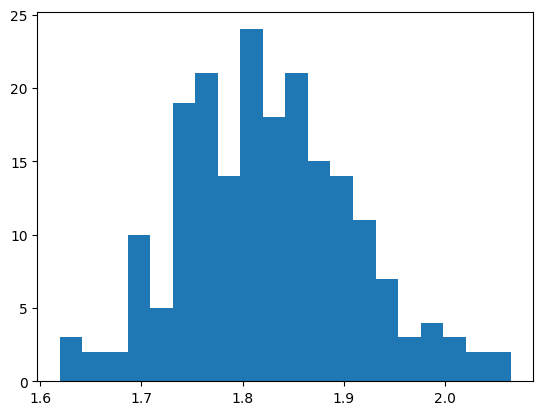

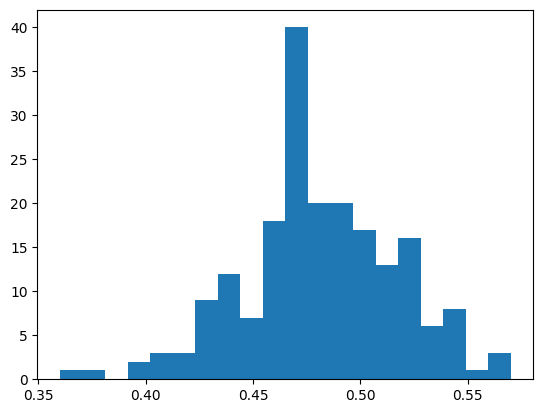

In [ ]:
#Euclidean Distance
# we can also check the variance per validation "episode" to see how much accuracy differs
# based on chosen classes as well as the support/query samples for each class
losses, accs = validate_per_episode(valid_dataloader, model, distance_fn=euclidean_distance,
                                   loss_fn=loss_fn, device=device)

plt.hist(losses, bins=20)
plt.show()

plt.hist(accs, bins=20)
plt.show()

In [ ]:
#Squared Euclidean Distance
metrics_Squared = train_model(model, loss_fn, optimizer, scheduler, train_dataloader, valid_dataloader,
                      n_epochs=200, device=device)

Running 200 epochs at 200 steps per epoch.
Starting epoch 1... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 49.69621539500076 seconds
	Train/val loss: 11.642092220783233 / 11.008309364318848
	Train/val accuracy: 0.4898749874532223 / 0.4558749794960022
	LR is now 2.4299999999999996e-06
Starting epoch 2... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.743366974998935 seconds
	Train/val loss: 8.567602996826173 / 8.76397705078125
	Train/val accuracy: 0.45387498930096626 / 0.43347498774528503
	LR is now 7.289999999999998e-07
Starting epoch 3... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 49.73928696699841 seconds
	Train/val loss: 7.4238994336128235 / 8.401107788085938
	Train/val accuracy: 0.4481249901652336 / 0.4309999942779541
	LR is now 7.289999999999998e-07
Starting epoch 4... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 49.85884545999943 seconds
	Train/val loss: 7.015458574295044 / 8.041498184204102
	Train/val accuracy: 0.4457499901950359 / 0.4239499866962433
	LR is now 7.289999999999998e-07
Starting epoch 5... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.40935914900001 seconds
	Train/val loss: 6.756242644786835 / 7.7568678855896
	Train/val accuracy: 0.4333249904215336 / 0.4144499897956848
	LR is now 7.289999999999998e-07
Starting epoch 6... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.4744791739995 seconds
	Train/val loss: 6.480945019721985 / 7.471837520599365
	Train/val accuracy: 0.42564998894929884 / 0.4144749939441681
	LR is now 7.289999999999998e-07
Starting epoch 7... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.86269138900025 seconds
	Train/val loss: 6.2744223761558535 / 7.21511173248291
	Train/val accuracy: 0.42104998990893366 / 0.4135749936103821
	LR is now 7.289999999999998e-07
Starting epoch 8... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.81207574600012 seconds
	Train/val loss: 5.98255514383316 / 6.978790283203125
	Train/val accuracy: 0.42487498983740807 / 0.40664997696876526
	LR is now 2.1869999999999994e-07
Starting epoch 9... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.43766235100156 seconds
	Train/val loss: 5.9319922065734865 / 6.854949951171875
	Train/val accuracy: 0.41299999117851255 / 0.4065999984741211
	LR is now 2.1869999999999994e-07
Starting epoch 10... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.50604592499985 seconds
	Train/val loss: 5.8349520468711855 / 6.83549690246582
	Train/val accuracy: 0.41847499027848245 / 0.4052249789237976
	LR is now 2.1869999999999994e-07
Starting epoch 11... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.19526425299955 seconds
	Train/val loss: 5.827605311870575 / 6.779367446899414
	Train/val accuracy: 0.40924998953938485 / 0.40332499146461487
	LR is now 2.1869999999999994e-07
Starting epoch 12... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.23040086600122 seconds
	Train/val loss: 5.764444377422333 / 6.680633544921875
	Train/val accuracy: 0.4084249900281429 / 0.4003250002861023
	LR is now 2.1869999999999994e-07
Starting epoch 13... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 49.43097636700077 seconds
	Train/val loss: 5.726207695007324 / 6.613426208496094
	Train/val accuracy: 0.4082999911904335 / 0.4031499922275543
	LR is now 2.1869999999999994e-07
Starting epoch 14... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.40806952899948 seconds
	Train/val loss: 5.610733442306518 / 6.558043003082275
	Train/val accuracy: 0.40469998940825463 / 0.400299996137619
	LR is now 6.560999999999998e-08
Starting epoch 15... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 47.19861019199925 seconds
	Train/val loss: 5.613770885467529 / 6.570844650268555
	Train/val accuracy: 0.40619998961687087 / 0.3995499908924103
	LR is now 6.560999999999998e-08
Starting epoch 16... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.22555364599975 seconds
	Train/val loss: 5.570182874202728 / 6.504615783691406
	Train/val accuracy: 0.40487499177455905 / 0.3992999792098999
	LR is now 6.560999999999998e-08
Starting epoch 17... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 46.86850018500081 seconds
	Train/val loss: 5.537829735279083 / 6.546442031860352
	Train/val accuracy: 0.40209999069571495 / 0.3974999785423279
	LR is now 6.560999999999998e-08
Starting epoch 18... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 46.61937652800043 seconds
	Train/val loss: 5.512327225208282 / 6.489212989807129
	Train/val accuracy: 0.40662499085068704 / 0.39617499709129333
	LR is now 6.560999999999998e-08
Starting epoch 19... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 45.87279689100069 seconds
	Train/val loss: 5.483801777362824 / 6.477787494659424
	Train/val accuracy: 0.40682499185204507 / 0.39442500472068787
	LR is now 6.560999999999998e-08
Starting epoch 20... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 47.059879125001316 seconds
	Train/val loss: 5.563982999324798 / 6.403928756713867
	Train/val accuracy: 0.3926249907165766 / 0.3992749750614166
	LR is now 1.9682999999999992e-08
Starting epoch 21... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 47.25809704300082 seconds
	Train/val loss: 5.503306360244751 / 6.395573139190674
	Train/val accuracy: 0.4035749898850918 / 0.39444997906684875
	LR is now 1.9682999999999992e-08
Starting epoch 22... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 48.08063575500091 seconds
	Train/val loss: 5.443941259384156 / 6.458178997039795
	Train/val accuracy: 0.4066499917209148 / 0.39787498116493225
	LR is now 1.9682999999999992e-08
Starting epoch 23... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 47.033632930999374 seconds
	Train/val loss: 5.431216249465942 / 6.309172630310059
	Train/val accuracy: 0.4019249901175499 / 0.3968749940395355
	LR is now 1.9682999999999992e-08
Starting epoch 24... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 47.39310658500108 seconds
	Train/val loss: 5.4802212595939634 / 6.3959574699401855
	Train/val accuracy: 0.4060749907791614 / 0.39444997906684875
	LR is now 1.9682999999999992e-08
Starting epoch 25... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best value found; no longer disappointed
Time taken: 47.89030356399962 seconds
	Train/val loss: 5.513827044963836 / 6.269144535064697
	Train/val accuracy: 0.3980999904870987 / 0.3982499837875366
	LR is now 1.9682999999999992e-08
Starting epoch 26... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 1
Time taken: 46.936654430999624 seconds
	Train/val loss: 5.4363106966018675 / 6.350884914398193
	Train/val accuracy: 0.40527498997747896 / 0.3957499861717224
	LR is now 5.904899999999998e-09
Starting epoch 27... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 2
Time taken: 46.86541417399894 seconds
	Train/val loss: 5.443775837421417 / 6.363316535949707
	Train/val accuracy: 0.40434999004006383 / 0.3991749882698059
	LR is now 5.904899999999998e-09
Starting epoch 28... EarlyStopping disappointment increased to 3
Time taken: 45.76536405399929 seconds
	Train/val loss: 5.452301306724548 / 6.424893856048584
	Train/val accuracy: 0.3966749909520149 / 0.39499998092651367
	LR is now 5.904899999999998e-09
Starting epoch 29... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 4
Time taken: 47.40931595700022 seconds
	Train/val loss: 5.406950123310089 / 6.398061275482178
	Train/val accuracy: 0.40452498957514765 / 0.39697498083114624
	LR is now 5.904899999999998e-09
Starting epoch 30... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 5
Time taken: 46.09260441200058 seconds
	Train/val loss: 5.46981253862381 / 6.44927453994751
	Train/val accuracy: 0.4040499909222126 / 0.3956249952316284
	LR is now 5.904899999999998e-09
Starting epoch 31... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 6
Time taken: 46.09779924299983 seconds
	Train/val loss: 5.4104467034339905 / 6.467247009277344
	Train/val accuracy: 0.40144999042153356 / 0.39307498931884766
	LR is now 5.904899999999998e-09
Starting epoch 32... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 7
Time taken: 47.71082541400028 seconds
	Train/val loss: 5.450411808490753 / 6.421539306640625
	Train/val accuracy: 0.39917499110102656 / 0.39424997568130493
	LR is now 5.904899999999998e-09
Starting epoch 33... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 8
Time taken: 49.91837148100058 seconds
	Train/val loss: 5.4372700548171995 / 6.468271732330322
	Train/val accuracy: 0.40777498960494996 / 0.38964998722076416
	LR is now 5.904899999999998e-09
Starting epoch 34... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 9
Time taken: 49.52831975200024 seconds
	Train/val loss: 5.407926061153412 / 6.407474040985107
	Train/val accuracy: 0.40217499107122423 / 0.3939499855041504
	LR is now 5.904899999999998e-09
Starting epoch 35... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 10
Time taken: 50.730264499999976 seconds
	Train/val loss: 5.46425550699234 / 6.369032859802246
	Train/val accuracy: 0.399849990606308 / 0.3936249911785126
	LR is now 5.904899999999998e-09
Starting epoch 36... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 11
Time taken: 49.42369046299973 seconds
	Train/val loss: 5.357383897304535 / 6.403407573699951
	Train/val accuracy: 0.40677499055862426 / 0.3922500014305115
	LR is now 5.904899999999998e-09
Starting epoch 37... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 12
Time taken: 50.22200512100062 seconds
	Train/val loss: 5.401882703304291 / 6.3647918701171875
	Train/val accuracy: 0.40517499059438705 / 0.39947497844696045
	LR is now 5.904899999999998e-09
Starting epoch 38... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 13
Time taken: 49.993723112000225 seconds
	Train/val loss: 5.423116321563721 / 6.2783637046813965
	Train/val accuracy: 0.4057499910891056 / 0.39959999918937683
	LR is now 5.904899999999998e-09
Starting epoch 39... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 14
Time taken: 48.555921731000126 seconds
	Train/val loss: 5.410124180316925 / 6.393077850341797
	Train/val accuracy: 0.40004999093711374 / 0.39684998989105225
	LR is now 5.904899999999998e-09
Starting epoch 40... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 15
Time taken: 49.79142257199965 seconds
	Train/val loss: 5.473916003704071 / 6.366661071777344
	Train/val accuracy: 0.395474990606308 / 0.3939249813556671
	LR is now 5.904899999999998e-09
Starting epoch 41... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EarlyStopping disappointment increased to 16
EarlyStopping has become too disappointed; now would be a good time to cancel training
Restoring best model from state_dict
Time taken: 49.809541606000494 seconds
	Train/val loss: 5.483104932308197 / 6.447571277618408
	Train/val accuracy: 0.3987749908864498 / 0.39512500166893005
	LR is now 5.904899999999998e-09
Early stopping...


In [ ]:
#Squared Euclidean Distance
validate(valid_dataloader, model, distance_fn=squared_euclidean_distance,
         loss_fn=loss_fn, device=device)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(tensor(6.4107, device='cuda:0'), tensor(0.3978, device='cuda:0'))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


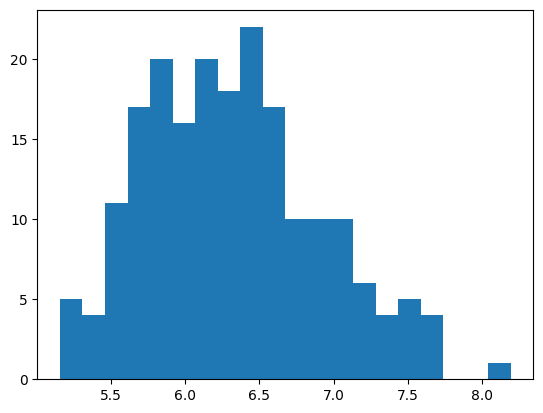

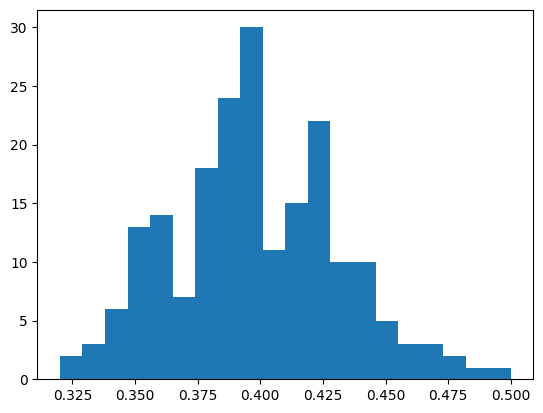

In [ ]:
#Squared Euclidean Distance
losses, accs = validate_per_episode(valid_dataloader, model, distance_fn=squared_euclidean_distance,
                                   loss_fn=loss_fn, device=device)

plt.hist(losses, bins=20)
plt.show()

plt.hist(accs, bins=20)
plt.show()